# Classifier for SG and DG events BEFORE reconstruction

# Check toy detector

In [4]:
import ToyDetector
import pandas as pd

# Example usage:
# Create the detector
detector = ToyDetector.ToyDetector()

# Simulate a filtered dataframe with example tracks
data = {
    'Event ID': [1, 1, 1],
    'px': [10, 20, 15],
    'py': [10, 5, 20],
    'pz': [30, 40, 50],
    'c*tau': [0.5, 1.0, 0.2],
    'PDG ID': [211, -211, 111]
}

df = pd.DataFrame(data)

In [5]:
%matplotlib qt

In [3]:
detector.visualize_detector_3d()


In [4]:
detector.visualize_event(df, event_number=1, dashed=True, line_color='green')


In [6]:
data2 = {
    'Event ID': [2, 2, 2],
    'px': [30, 40, 20],
    'py': [10, 15, 20],
    'pz': [50, 10, 20],
    'c*tau': [0.5, 1.0, 0.2],
    'PDG ID': [211, -211, 111]
}

df2 = pd.DataFrame(data2)
detector.visualize_event(df2, event_number=2, dashed=True, line_color='green')


In [8]:
data3 = {
    'Event ID': [3],
    'px': [1],
    'py': [1],
    'pz': [100],
    'c*tau': [10.],
    'PDG ID': [211]
}

df3 = pd.DataFrame(data3)
detector.visualize_event(df3, event_number=3, dashed=True, line_color='green')


### Code to parse the typical STARlight output

In [9]:
import pandas as pd

def parse_starlight_output(file_path):
    events = []
    vertices = []
    tracks = []
    
    with open(file_path, 'r') as file:
        current_event = None
        current_vertex = None
        
        for line in file:
            if line.startswith("EVENT"):
                if current_event:
                    events.append(current_event)
                event_data = line.split()
                current_event = {
                    "Event Number": int(event_data[1]),
                    "Number of Tracks": int(event_data[2]),
                    "Number of Vertices": int(event_data[3]),
                    "Vertices": [],
                    "Tracks": []
                }
            elif line.startswith("VERTEX"):
                vertex_data = line.split()
                current_vertex = {
                    "x": float(vertex_data[1]),
                    "y": float(vertex_data[2]),
                    "z": float(vertex_data[3]),
                    "t": float(vertex_data[4]),
                    "Vertex Number": int(vertex_data[5]),
                    "Process Number": int(vertex_data[6]),
                    "Parent Track": int(vertex_data[7]),
                    "Number of Daughters": int(vertex_data[8])
                }
                current_event["Vertices"].append(current_vertex)
            elif line.startswith("TRACK"):
                track_data = line.split()
                track = {
                    "GPID": int(track_data[1]),
                    "px": float(track_data[2]),
                    "py": float(track_data[3]),
                    "pz": float(track_data[4]),
                    "Event Number": int(track_data[5]),
                    "Track Number": int(track_data[6]),
                    "Stop Vertex": int(track_data[7]),
                    "PDGPID": int(track_data[8])
                }
                current_event["Tracks"].append(track)
        
        if current_event:
            events.append(current_event)
    
    # Flatten the data into lists of dictionaries for DataFrame conversion
    event_list = []
    vertex_list = []
    track_list = []
    
    for event in events:
        event_list.append({
            "Event Number": event["Event Number"],
            "Number of Tracks": event["Number of Tracks"],
            "Number of Vertices": event["Number of Vertices"]
        })
        
        for vertex in event["Vertices"]:
            vertex["Event Number"] = event["Event Number"]
            vertex_list.append(vertex)
        
        for track in event["Tracks"]:
            track_list.append(track)
    
    # Convert to DataFrames
    event_df = pd.DataFrame(event_list)
    vertex_df = pd.DataFrame(vertex_list)
    track_df = pd.DataFrame(track_list)
    
    return event_df, vertex_df, track_df


# Example usage
file_path = 'slight-jpsi.out'
event_df, vertex_df, track_df = parse_starlight_output(file_path)

# Display the first few rows of each DataFrame
event_df.head(), vertex_df.head(), track_df.head()


(   Event Number  Number of Tracks  Number of Vertices
 0             1                 2                   1
 1             2                 2                   1
 2             3                 2                   1
 3             4                 2                   1
 4             5                 2                   1,
      x    y    z    t  Vertex Number  Process Number  Parent Track  \
 0  0.0  0.0  0.0  0.0              1               0             0   
 1  0.0  0.0  0.0  0.0              1               0             0   
 2  0.0  0.0  0.0  0.0              1               0             0   
 3  0.0  0.0  0.0  0.0              1               0             0   
 4  0.0  0.0  0.0  0.0              1               0             0   
 
    Number of Daughters  Event Number  
 0                    2             1  
 1                    2             2  
 2                    2             3  
 3                    2             4  
 4                    2             5  ,


## Step 2: Compute c⋅τ for Each Particle

In [10]:
# Define the speed of light in meters per second (m/s)
c = 299792458  # Speed of light in m/s

# Define a dictionary of proper lifetimes (in seconds) for some particles based on PDG ID
pdg_lifetimes = {
    11: 999999999.,   # Electron (e-), considered stable
    -11: 999999999.,  # Positron (e+), considered stable
    13: 2.197e-6,     # Muon (mu-)
    -13: 2.197e-6,    # Anti-Muon (mu+)
    211: 2.6033e-8,   # Charged pion (pi+)
    -211: 2.6033e-8,  # Charged pion (pi-)
    111: 8.4e-17,     # Neutral pion (pi0)
    310: 8.954e-11,   # Neutral kaon (K0_S)
    321: 1.238e-8,    # Charged kaon (K+)
    -321: 1.238e-8,   # Charged kaon (K-)
    3122: 2.632e-10,  # Lambda (Λ)
    2212: 999999999., # Proton (p), considered stable
    2112: 881.5,      # Neutron (n)
    22: 999999999.,   # Photon (gamma), does not decay
    # Add more particles as needed
}

def calculate_c_tau(pdg_id):
    """
    Calculates the quantity c*tau for particles using their PDG ID.

    Parameters:
    pdg_id (float): the 'PDG ID' for a track.

    Returns:
    float: The value of c*tau for the particle in meters.
    """    
    # Get the proper lifetime for the particle from the PDG ID
    lifetime = pdg_lifetimes.get(abs(pdg_id), None)
    
    if lifetime is None or lifetime == float('inf'):
        return None  # Lifetime is unknown or particle is stable
    
    # Calculate c*tau
    c_tau = c * lifetime
    
    return c_tau



## Step 3: Convert Tracks to Lorentz Vectors, Include PDG ID, and Group by Event

In [11]:
import vector


def create_lorentz_vector(px, py, pz, mass):
    vec = vector.obj(px=px, py=py, pz=pz, E=(px**2 + py**2 + pz**2 + mass**2)**0.5)
    return vec

def get_mass_from_pdgid(pdgid):
    """
    Returns the mass in GeV/c^2 based on the PDG ID code.

    Parameters:
    pdgid (int): PDG ID code of the particle.

    Returns:
    float: Mass of the particle in GeV/c^2.
    """
    pdg_masses = {
        11: 0.000511,   # Electron mass in GeV/c^2
        13: 0.10566,    # Muon mass in GeV/c^2
        211: 0.13957,   # Charged Pion (pi+) mass in GeV/c^2
        3122: 1.11568,  # Lambda (Λ) mass in GeV/c^2
        111: 0.134977,  # Neutral Pion (pi0) mass in GeV/c^2
        2112: 0.939565, # Neutron (n) mass in GeV/c^2
        2212: 0.938272, # Proton (p) mass in GeV/c^2
        321: 0.493677,  # Charged Kaon (K+) mass in GeV/c^2
        22: 0.0,        # Photon (γ) mass in GeV/c^2 (massless)
        310: 0.497611,  # Neutral Kaon (K0_S) mass in GeV/c^2
    }
    return pdg_masses.get(abs(pdgid), 0)  # Default to 0 if mass is unknown

def process_starlight_tracks_to_df(event_df, track_df):
    """
    Processes STARlight simulation data into a track-based DataFrame.

    Each row in the resulting DataFrame corresponds to a track, and the columns contain the event ID, 
    momentum components (px, py, pz), energy, mass, PDG ID, and c*tau.

    Parameters:
    event_df (DataFrame): DataFrame containing event data.
    track_df (DataFrame): DataFrame containing track data, including momentum components and PDG IDs.

    Returns:
    DataFrame: A DataFrame where each row is a track, with columns for event ID, px, py, pz, energy, mass, PDG ID, and c*tau.
    """

    track_list = []

    # Iterate over each unique event
    for event_number in event_df['Event Number'].unique():
        # Filter tracks for the current event
        event_tracks = track_df[track_df['Event Number'] == event_number]

        # Process each track
        for _, track in event_tracks.iterrows():
            mass = get_mass_from_pdgid(track['PDGPID'])
            energy = (track['px']**2 + track['py']**2 + track['pz']**2 + mass**2)**0.5
            ctau = calculate_c_tau(track['PDGPID'])
            
            # Append track information to the list
            track_list.append({
                'Event ID': event_number,
                'px': track['px'],
                'py': track['py'],
                'pz': track['pz'],
                'Energy': energy,
                'Mass': mass,
                'PDG ID': track['PDGPID'],
                'c*tau': ctau
            })

    # Convert the list of tracks to a DataFrame
    tracks_df = pd.DataFrame(track_list)

    return tracks_df

# Example usage
# Assuming the STARlight output has already been parsed into event_df and track_df
tracks_df = process_starlight_tracks_to_df(event_df, track_df)

# Display the first few rows of the processed DataFrame
tracks_df.head()

,Event ID,px,py,pz,Energy,Mass,PDG ID,c*tau
0,1,1.544090,0.102887,-0.308441,1.577953,0.000511,11.0,2.997925e+17
1,1,-1.532450,-0.074757,0.001463,1.534273,0.000511,-11.0,2.997925e+17
2,2,0.849749,-0.936002,1.077760,1.661247,0.000511,11.0,2.997925e+17
3,2,-0.922957,0.947017,-0.636935,1.467780,0.000511,-11.0,2.997925e+17
4,3,1.094530,1.022950,-0.091118,1.500908,0.000511,11.0,2.997925e+17


## Step 4: Filter Tracks Based on c⋅τ Threshold

In [12]:
def filter_long_lived_particles(tracks_df, threshold=0.1):
    """
    Filters out tracks from the DataFrame where c*tau < threshold.

    Parameters:
    tracks_df (DataFrame): DataFrame containing track data, including c*tau values.
    threshold (float): The threshold for c*tau below which tracks will be removed (default is 0.1 meters, or 10 cm).

    Returns:
    DataFrame: The filtered DataFrame containing only tracks where c*tau >= threshold.
    """

    # Filter the DataFrame based on the c*tau threshold
    filtered_tracks_df = tracks_df[tracks_df['c*tau'] >= threshold].copy()

    return filtered_tracks_df

# Example usage
# Assuming `tracks_df` is the DataFrame generated by `process_starlight_tracks_to_df`
long_lived_tracks_df = filter_long_lived_particles(tracks_df, threshold=0.1)

# Display the first few rows of the filtered DataFrame
long_lived_tracks_df.head()


,Event ID,px,py,pz,Energy,Mass,PDG ID,c*tau
0,1,1.544090,0.102887,-0.308441,1.577953,0.000511,11.0,2.997925e+17
1,1,-1.532450,-0.074757,0.001463,1.534273,0.000511,-11.0,2.997925e+17
2,2,0.849749,-0.936002,1.077760,1.661247,0.000511,11.0,2.997925e+17
3,2,-0.922957,0.947017,-0.636935,1.467780,0.000511,-11.0,2.997925e+17
4,3,1.094530,1.022950,-0.091118,1.500908,0.000511,11.0,2.997925e+17


In [13]:
# File paths for the datasets
file_paths = {
    'jpsi': 'slight-jpsi.out',
    'photon_photon': 'slight-gg.out',
    'dissociative': 'slight_k10000.out'
}

# Function to process each dataset
def process_dataset(file_path):
    # Parse the STARlight output
    event_df, vertex_df, track_df = parse_starlight_output(file_path)
    
    # Convert tracks to Lorentz vectors and include PDG IDs
    processed_df = process_starlight_tracks_to_df(event_df, track_df)
        
    # Filter tracks based on c*tau < 10 cm
    filtered_df = filter_long_lived_particles(processed_df, threshold=0.1)
    
    return filtered_df

# Process each dataset and store the results
filtered_results = {}
for process_name, file_path in file_paths.items():
    filtered_results[process_name] = process_dataset(file_path)
    print(f"Processed {process_name}: {filtered_results[process_name].shape[0]} events with tracks meeting the c*tau threshold.")

# Example: Access the filtered DataFrame for Jpsi
filtered_jpsi_df = filtered_results['jpsi']
filtered_photon_photon_df = filtered_results['photon_photon']
filtered_dissociative_df = filtered_results['dissociative']

# Display the first few rows of the filtered Jpsi DataFrame
filtered_jpsi_df.head()
filtered_photon_photon_df.head()
filtered_dissociative_df.head()


Processed jpsi: 107524 events with tracks meeting the c*tau threshold.
Processed photon_photon: 200000 events with tracks meeting the c*tau threshold.
Processed dissociative: 2376885 events with tracks meeting the c*tau threshold.


,Event ID,px,py,pz,Energy,Mass,PDG ID,c*tau
0,1,0.077239,-0.123942,-0.119947,0.528613,0.493677,-321.0,3.711431e+00
1,1,0.685224,-0.243395,-11.084400,11.109103,0.139570,-211.0,7.804497e+00
5,1,-0.328124,-0.286102,-0.504740,0.681001,0.139570,-211.0,7.804497e+00
6,1,0.502813,-0.314321,-8.314980,8.337265,0.139570,211.0,7.804497e+00
7,1,-1.355490,0.093479,-0.347084,1.687999,0.939565,-2112.0,2.642671e+11


In [14]:
detector.visualize_event(filtered_dissociative_df, event_number=1, dashed=True, line_color='green')


In [15]:
detector.visualize_event(filtered_jpsi_df, event_number=1, dashed=True, line_color='green')


## Step 5: Feature extraction

In [21]:
import pandas as pd
import numpy as np

def create_crossed_modules_df(detector, df):
    """
    Creates a new dataframe with Event ID and the list of Crossed MODULE IDs for each event.
    
    Parameters:
    detector (ToyDetector): The instance of the ToyDetector class.
    df (pd.DataFrame): The filtered dataframe containing track information.
    
    Returns:
    pd.DataFrame: A new dataframe with 'Event ID' and 'Crossed MODULE IDs'.
    """
    # Initialize a list to store the results
    results = []

    # Group the dataframe by 'Event ID'
    grouped = df.groupby('Event ID')

    # Iterate over each group (event)
    for event_number, group in grouped:
        # Get the list of crossed module IDs for this event
        crossed_module_ids = detector.compute_crossed_detector_elements(df, event_number)
        
        # Append the result to the list
        results.append({'Event ID': event_number, 'Crossed MODULE IDs': crossed_module_ids})
    
    # Convert the list of results into a DataFrame
    crossed_modules_df = pd.DataFrame(results)
    
    return crossed_modules_df

# Assuming detector is an instance of ToyDetector and df_filtered is your filtered dataframe
filtered_jpsi_crossed_df = create_crossed_modules_df(detector, filtered_jpsi_df)
filtered_photon_photon_crossed_df = create_crossed_modules_df(detector, filtered_photon_photon_df)
filtered_dissociative_crossed_df = create_crossed_modules_df(detector, filtered_dissociative_df)

# Display the first few rows to check the result
filtered_jpsi_crossed_df.head()


,Event ID,Crossed MODULE IDs
0,1,[40]
1,2,"[320, 34]"
2,3,[40]
3,4,[35]
4,5,[64]


In [6]:
import pandas as pd
import numpy as np

def load_features_from_file(filename, file_format='csv'):
    """
    Loads the feature dataframe from a file.
    
    Parameters:
    filename (str): The name of the file to load the dataframe from.
    file_format (str): The format of the file ('csv' or 'excel').
    
    Returns:
    pd.DataFrame: The loaded dataframe containing extracted features.
    """
    if file_format == 'csv':
        features_df = pd.read_csv(filename)
        print(f"Features loaded from {filename} as a CSV file.")
    elif file_format == 'excel':
        features_df = pd.read_excel(filename)
        print(f"Features loaded from {filename} as an Excel file.")
    else:
        raise ValueError("Unsupported file format. Please choose 'csv' or 'excel'.")
    
    return features_df

# Example usage:
# Load the features DataFrame from a CSV file
filtered_jpsi_crossed_df = load_features_from_file('filtered_jpsi_crossed_df.csv', file_format='csv')
filtered_photon_photon_crossed_df = load_features_from_file('filtered_photon_photon_crossed_df.csv', file_format='csv')
filtered_dissociative_crossed_df = load_features_from_file('filtered_dissociative_crossed_df.csv', file_format='csv')


Features loaded from filtered_jpsi_crossed_df.csv as a CSV file.
Features loaded from filtered_photon_photon_crossed_df.csv as a CSV file.
Features loaded from filtered_dissociative_crossed_df.csv as a CSV file.


In [7]:
def extract_features_from_filtered_df(crossed_modules_df, detector):
    """
    Extracts features from the Crossed MODULE IDs dataframe.
    
    Parameters:
    crossed_modules_df (pd.DataFrame): The dataframe with 'Event ID' and 'Crossed MODULE IDs'.
    detector (ToyDetector): The instance of the ToyDetector class.
    
    Returns:
    pd.DataFrame: A new dataframe with extracted features for each event.
    """
    # Initialize a list to store the extracted features
    features = []

    # Iterate over each row in the crossed_modules_df
    for _, row in crossed_modules_df.iterrows():
        event_id = row['Event ID']
        crossed_ids = row['Crossed MODULE IDs']
        
        # Determine if more than one module was activated in each component
        cylinder_ids = [module['module_ID'] for module in detector.modules if module['type'] == 'cylinder']
        planar1_ids = [module['module_ID'] for module in detector.modules if module['type'] == 'planar' and module['z_pos'] == detector.planar_z1]
        planar2_ids = [module['module_ID'] for module in detector.modules if module['type'] == 'planar' and module['z_pos'] == detector.planar_z2]

        # Check if more than one module was activated in each component
        more_than_one_cylinder = len(set(crossed_ids) & set(cylinder_ids)) > 1
        more_than_one_planar1 = len(set(crossed_ids) & set(planar1_ids)) > 1
        more_than_one_planar2 = len(set(crossed_ids) & set(planar2_ids)) > 1
        
        # Calculate occupancy for each component
        cylinder_occupancy = len(set(crossed_ids) & set(cylinder_ids)) / len(cylinder_ids)
        planar1_occupancy = len(set(crossed_ids) & set(planar1_ids)) / len(planar1_ids)
        planar2_occupancy = len(set(crossed_ids) & set(planar2_ids)) / len(planar2_ids)

        # Check if occupancy is above 10% in each component
        cylinder_occupancy_above_10 = cylinder_occupancy > 0.1
        planar1_occupancy_above_10 = planar1_occupancy > 0.1
        planar2_occupancy_above_10 = planar2_occupancy > 0.1

        # Append the extracted features to the list
        features.append({
            'Event ID': event_id,
            'More than 1 Cylinder Module': more_than_one_cylinder,
            'More than 1 Planar1 Module': more_than_one_planar1,
            'More than 1 Planar2 Module': more_than_one_planar2,
            'Cylinder Occupancy > 10%': cylinder_occupancy_above_10,
            'Planar1 Occupancy > 10%': planar1_occupancy_above_10,
            'Planar2 Occupancy > 10%': planar2_occupancy_above_10
        })

    # Convert the list of features into a DataFrame
    features_df = pd.DataFrame(features)
    
    return features_df

# Example usage:
# Assuming crossed_modules_df is the DataFrame created by create_crossed_modules_df
features_jpsi_df = extract_features_from_filtered_df(filtered_jpsi_crossed_df, detector)
features_photon_photon_df = extract_features_from_filtered_df(filtered_photon_photon_crossed_df, detector)
features_dissociative_df = extract_features_from_filtered_df(filtered_dissociative_crossed_df, detector)

# Display the first few rows to check the result
features_jpsi_df.head()


,Event ID,More than 1 Cylinder Module,More than 1 Planar1 Module,More than 1 Planar2 Module,Cylinder Occupancy > 10%,Planar1 Occupancy > 10%,Planar2 Occupancy > 10%
0,1,False,False,False,False,False,False
1,2,False,False,False,False,False,False
2,3,False,False,False,False,False,False
3,4,False,False,False,False,False,False
4,5,False,False,False,False,False,False


In [8]:
features_photon_photon_df.head()


,Event ID,More than 1 Cylinder Module,More than 1 Planar1 Module,More than 1 Planar2 Module,Cylinder Occupancy > 10%,Planar1 Occupancy > 10%,Planar2 Occupancy > 10%
0,1,False,False,False,False,False,False
1,2,False,False,False,False,False,False
2,3,False,False,False,False,False,False
3,4,False,False,False,False,False,False
4,5,False,False,False,False,False,False


In [9]:
features_dissociative_df.head()

,Event ID,More than 1 Cylinder Module,More than 1 Planar1 Module,More than 1 Planar2 Module,Cylinder Occupancy > 10%,Planar1 Occupancy > 10%,Planar2 Occupancy > 10%
0,1,False,False,False,False,False,False
1,2,False,False,False,False,False,False
2,3,False,False,False,False,False,False
3,4,False,False,False,False,False,False
4,5,False,False,False,False,False,False


In [22]:
def save_features_to_file(features_df, filename, file_format='csv'):
    """
    Saves the feature dataframe to a file.
    
    Parameters:
    features_df (pd.DataFrame): The dataframe containing extracted features.
    filename (str): The name of the file to save the dataframe.
    file_format (str): The format in which to save the file ('csv' or 'excel').
    
    Returns:
    None
    """
    if file_format == 'csv':
        features_df.to_csv(filename, index=False)
        print(f"Features saved to {filename} as a CSV file.")
    elif file_format == 'excel':
        features_df.to_excel(filename, index=False)
        print(f"Features saved to {filename} as an Excel file.")
    else:
        raise ValueError("Unsupported file format. Please choose 'csv' or 'excel'.")

# Example usage:
# Assuming features_df is the DataFrame created by extract_features_from_filtered_df
save_features_to_file(features_jpsi_df, 'features_jpsi_df.csv', file_format='csv')
save_features_to_file(features_photon_photon_df, 'features_photon_photon_df.csv', file_format='csv')
save_features_to_file(features_dissociative_df, 'features_dissociative_df.csv', file_format='csv')


Features saved to filtered_jpsi_crossed_df.csv as a CSV file.
Features saved to filtered_photon_photon_crossed_df.csv as a CSV file.
Features saved to filtered_dissociative_crossed_df.csv as a CSV file.


In [23]:
features_jpsi_df = load_features_from_file('features_jpsi_df.csv', file_format='csv')
features_photon_photon_df = load_features_from_file('features_photon_photon_df.csv', file_format='csv')
features_dissociative_df = load_features_from_file('features_dissociative_df.csv', file_format='csv')


Features loaded from filtered_jpsi_crossed_df.csv as a CSV file.
Features loaded from filtered_photon_photon_crossed_df.csv as a CSV file.
Features loaded from filtered_dissociative_crossed_df.csv as a CSV file.


In [7]:
import numpy as np

def calculate_rapidity(px, py, pz, energy):
    """Calculate the rapidity of a particle."""
    return 0.5 * np.log((energy + pz) / (energy - pz))

def extract_features_from_filtered_df(filtered_df):
    """
    Extracts features from the filtered DataFrame by grouping tracks by event number.

    Features extracted:
    - Number of filtered tracks
    - Minimum rapidity difference from the beam rapidity on the left and right sides
    - Mass of the sum of all Lorentz vectors
    - Momentum of the sum of all Lorentz vectors
    - Transverse momentum (pT) of the sum of all Lorentz vectors

    Parameters:
    filtered_df (DataFrame): The filtered DataFrame containing track data.

    Returns:
    DataFrame: A DataFrame containing the extracted features for each event.
    """
    features = []

    # Beam rapidities for left and right sides
    beam_rapidity_left = -9
    beam_rapidity_right = 9

    grouped = filtered_df.groupby('Event ID')

    for event_number, group in grouped:
        num_tracks = len(group)
        
        # Initialize variables to store the sum of Lorentz vectors
        total_px = 0
        total_py = 0
        total_pz = 0
        total_energy = 0

        rapidities = []

        for _, track in group.iterrows():
            px = track['px']
            py = track['py']
            pz = track['pz']
            energy = track['Energy']
            
            # Sum the Lorentz vectors
            total_px += px
            total_py += py
            total_pz += pz
            total_energy += energy

            # Calculate rapidity
            rapidity = calculate_rapidity(px, py, pz, energy)
            rapidities.append(rapidity)
        
        # Calculate the invariant mass of the summed Lorentz vectors
        mass_sum = np.sqrt(total_energy**2 - (total_px**2 + total_py**2 + total_pz**2))

        # Calculate the total momentum and transverse momentum (pT)
        momentum_sum = np.sqrt(total_px**2 + total_py**2 + total_pz**2)
        pt_sum = np.sqrt(total_px**2 + total_py**2)

        # Calculate the minimum rapidity differences from the beam rapidities
        min_rapidity_diff_left = min(abs(rap - beam_rapidity_left) for rap in rapidities)
        min_rapidity_diff_right = min(abs(rap - beam_rapidity_right) for rap in rapidities)

        # Append the extracted features for this event
        features.append({
            'Event ID': event_number,
            'Number of Tracks': num_tracks,
            'Min Rapidity Diff Left': min_rapidity_diff_left,
            'Min Rapidity Diff Right': min_rapidity_diff_right,
            'Mass Sum': mass_sum,
            'Momentum Sum': momentum_sum,
            'pT Sum': pt_sum
        })

    # Convert the list of features into a DataFrame
    features_df = pd.DataFrame(features)

    return features_df

# Example usage
# Assuming `long_lived_tracks_df` is the filtered DataFrame
features_df = extract_features_from_filtered_df(long_lived_tracks_df)

# Display the first few rows of the extracted features DataFrame
features_df.head()


,Event ID,Number of Tracks,Min Rapidity Diff Left,Min Rapidity Diff Right,Mass Sum,Momentum Sum,pT Sum
0,1,2,8.801983,8.999046,3.096900,0.308483,0.030443
1,2,2,8.535254,8.226835,3.096934,0.446998,0.074032
2,3,2,8.939216,8.447509,3.096841,0.757621,0.040537
3,4,2,8.476546,9.446659,3.097315,1.569925,0.097047
4,5,2,9.332521,8.418444,3.096911,1.472822,0.065745


In [8]:
# Assuming the filtered DataFrames for the three processes are already available:
# - filtered_jpsi_df
# - filtered_photon_photon_df
# - filtered_dissociative_df

# Dictionary to hold the feature DataFrames
features_dfs = {}

# List of the datasets and their names
datasets = {
    'Jpsi': filtered_jpsi_df,
    'Photon+Photon': filtered_photon_photon_df,
    'Dissociative': filtered_dissociative_df
}

# Extract features for each dataset
for process_name, filtered_df in datasets.items():
    features_dfs[process_name] = extract_features_from_filtered_df(filtered_df)
    print(f"Extracted features for {process_name}: {features_dfs[process_name].shape[0]} events.")

# Example: Access the features DataFrame for Jpsi
features_jpsi_df = features_dfs['Jpsi']

# Display the first few rows of the extracted features for Jpsi
features_jpsi_df.head()


Extracted features for Jpsi: 53762 events.
Extracted features for Photon+Photon: 100000 events.
Extracted features for Dissociative: 49987 events.


,Event ID,Number of Tracks,Min Rapidity Diff Left,Min Rapidity Diff Right,Mass Sum,Momentum Sum,pT Sum
0,1,2,8.801983,8.999046,3.096900,0.308483,0.030443
1,2,2,8.535254,8.226835,3.096934,0.446998,0.074032
2,3,2,8.939216,8.447509,3.096841,0.757621,0.040537
3,4,2,8.476546,9.446659,3.097315,1.569925,0.097047
4,5,2,9.332521,8.418444,3.096911,1.472822,0.065745


## Step 6: Plot All Features for All Datasets

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_all_features_for_dataset(df, dataset_name):
    """
    Plots all features for a single dataset.

    Parameters:
    df (DataFrame): The DataFrame containing the extracted features for a single dataset.
    dataset_name (str): The name of the dataset (e.g., 'Jpsi', 'Photon+Photon', 'Dissociative').
    """
    # Extract feature names
    feature_names = df.columns

    # Determine the number of rows and columns for the grid of plots
    num_features = len(feature_names)
    num_cols = 2
    num_rows = (num_features + 1) // num_cols

    # Create a grid of subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

    # Flatten the axes array if necessary
    axes = axes.flatten()

    # Iterate over the features and create plots
    for i, feature in enumerate(feature_names):
        sns.histplot(df[feature], ax=axes[i], kde=True)
        axes[i].set_title(f'{feature} - {dataset_name}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Density')

    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


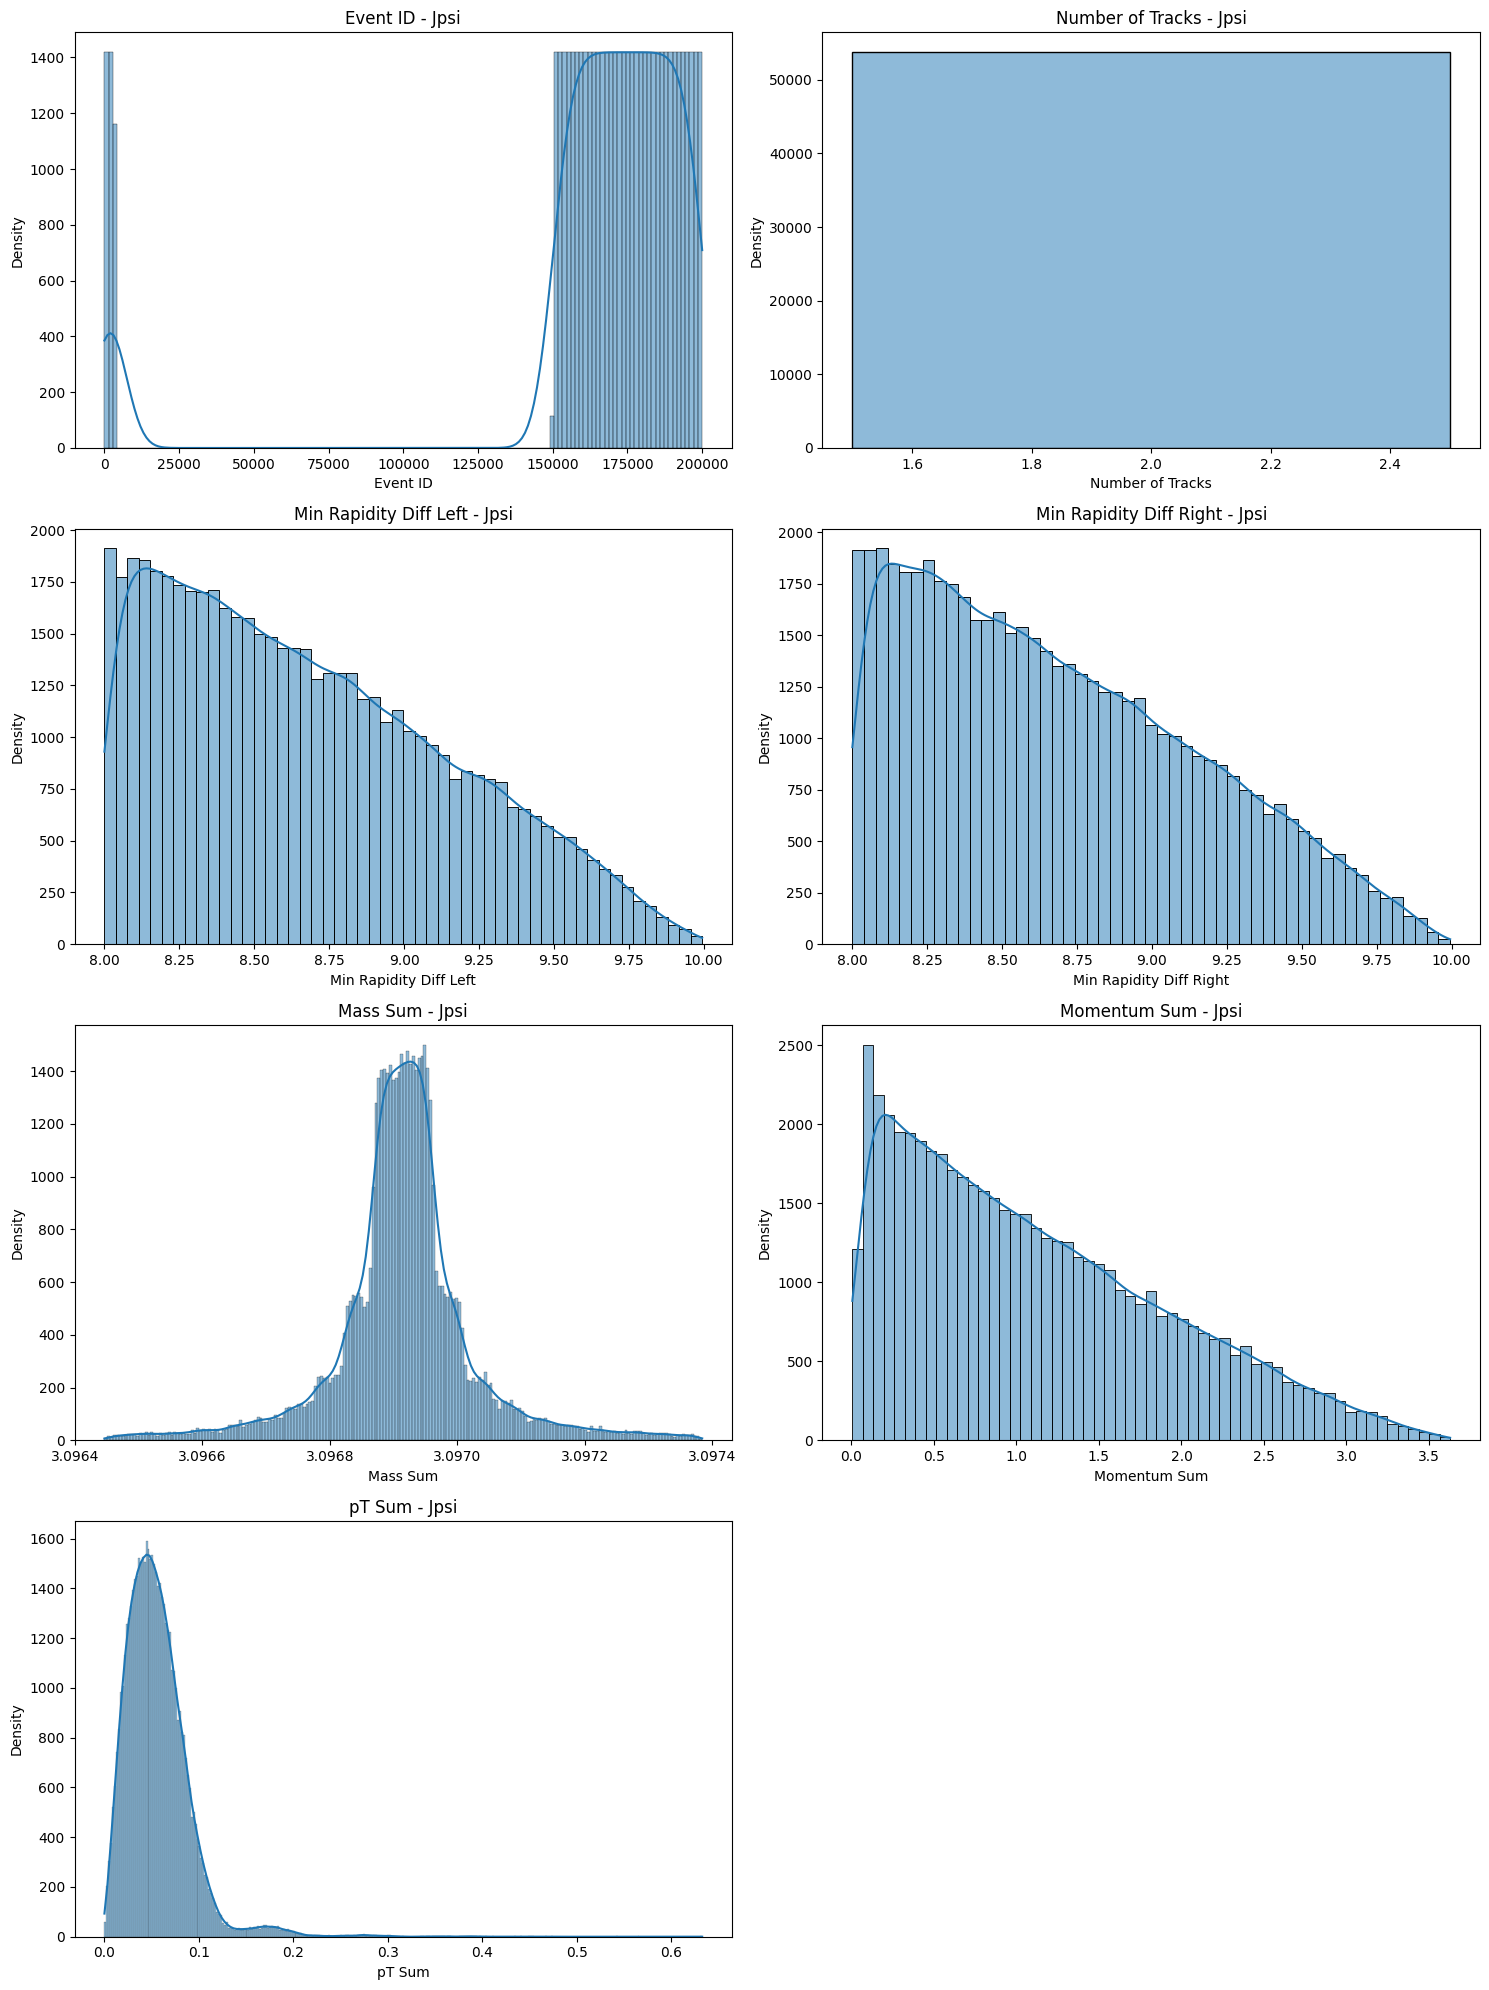

In [10]:
# Assuming the Jpsi dataset has been filtered and stored in `filtered_jpsi_df`
# features_jpsi_df = extract_features_from_filtered_data(filtered_jpsi_df)

# Plot all features for the Jpsi dataset
plot_all_features_for_dataset(features_jpsi_df, "Jpsi")


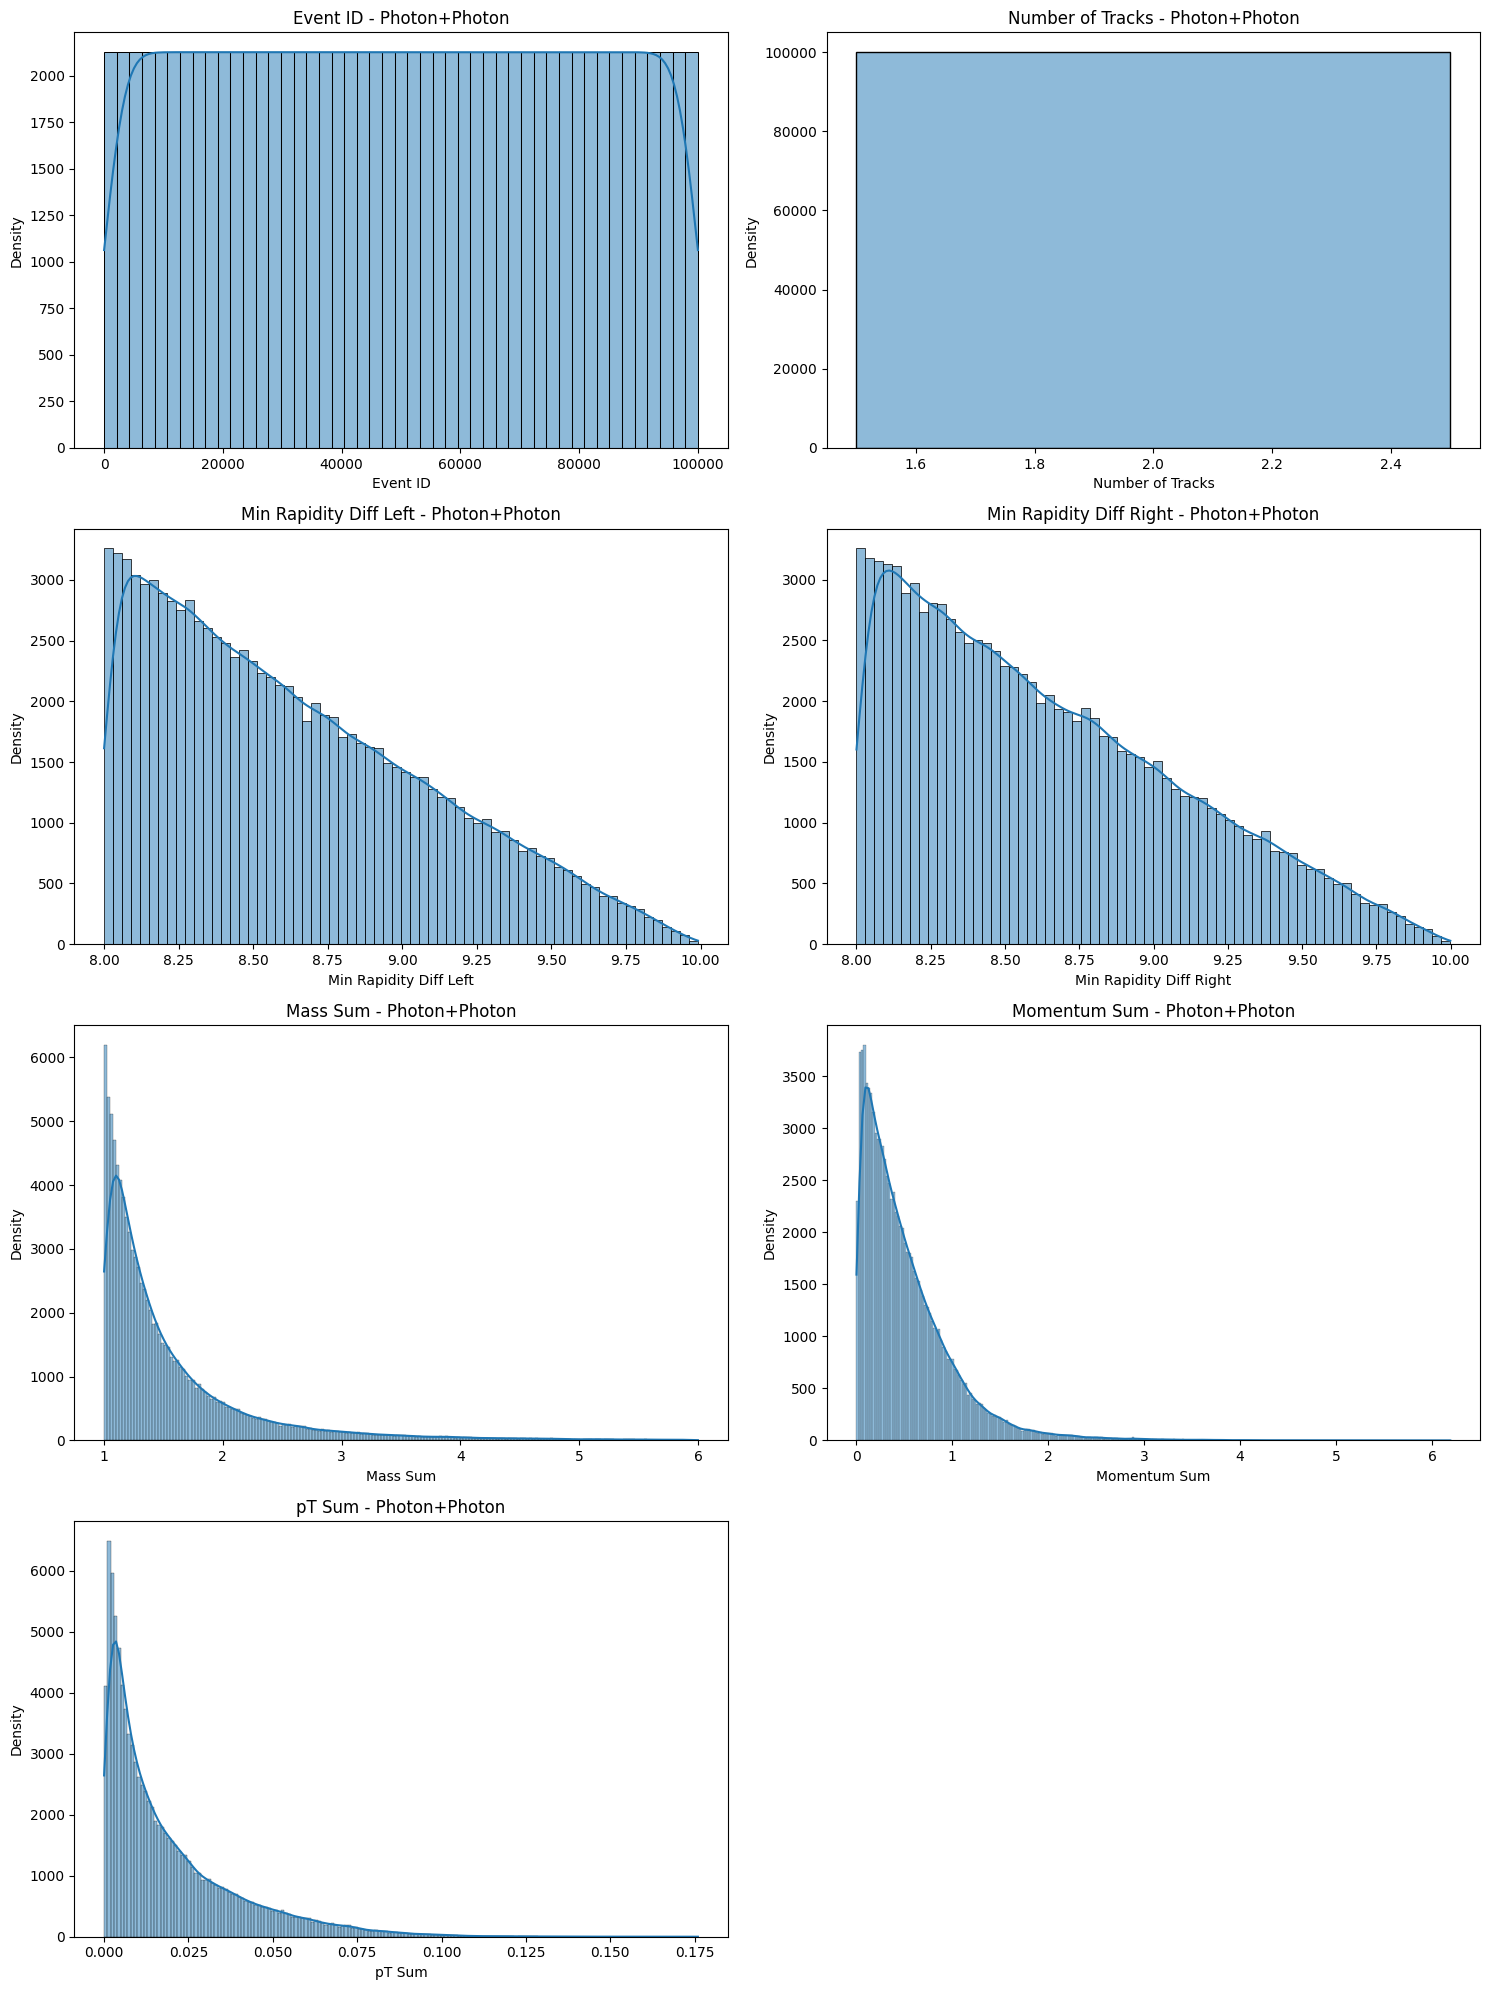

In [11]:
# Assuming the Photon+Photon dataset has been filtered and stored in `filtered_photon_photon_df`
features_photon_photon_df = features_dfs['Photon+Photon']

# Plot all features for the Photon+Photon dataset
plot_all_features_for_dataset(features_photon_photon_df, "Photon+Photon")


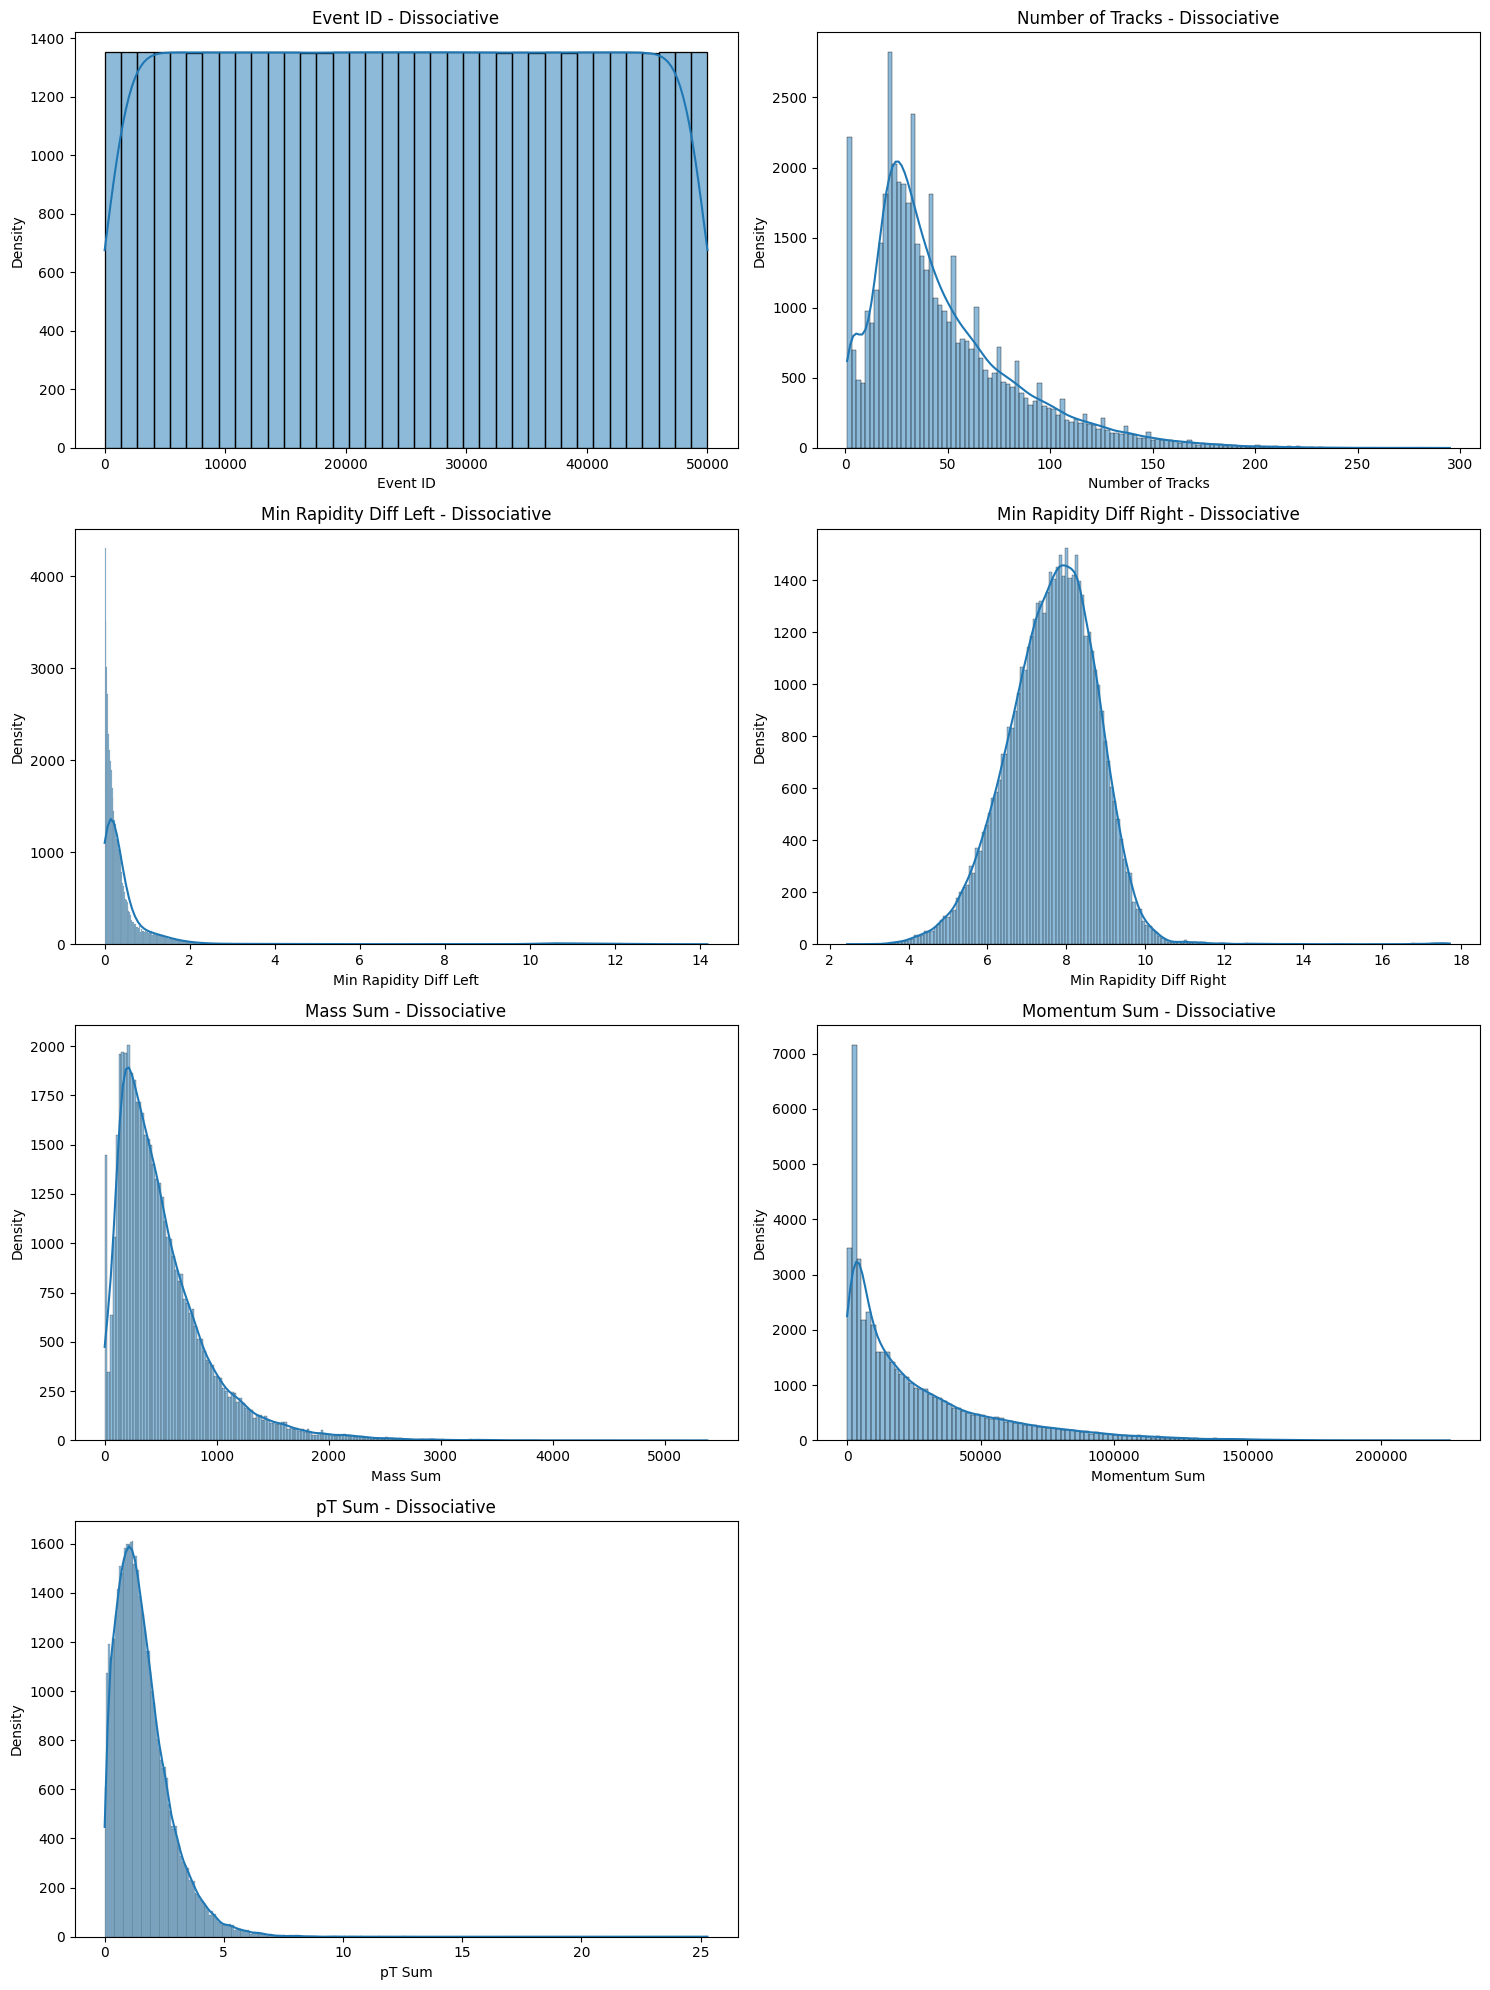

In [12]:
# Assuming the Dissociative dataset has been filtered and stored in `filtered_dissociative_df`
features_dissociative_df = features_dfs['Dissociative']

# Plot all features for the Dissociative dataset
plot_all_features_for_dataset(features_dissociative_df, "Dissociative")


## Step 7: Functions for aid


In [13]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_test, y_pred):
    """
    Plots the confusion matrix for the given predictions and true labels.

    Parameters:
    y_test (array-like): True labels.
    y_pred (array-like): Predicted labels.
    """
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

def plot_roc_curve(y_test, y_prob):
    """
    Plots the ROC curve and calculates the AUC.

    Parameters:
    y_test (array-like): True labels.
    y_prob (array-like): Predicted probabilities for the positive class.
    """
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def print_overall_performance(y_test, y_pred):
    """
    Prints the overall accuracy score and the classification report.

    Parameters:
    y_test (array-like): True labels.
    y_pred (array-like): Predicted labels.
    """
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy: {accuracy:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))


In [14]:
# Assign labels to the datasets
features_jpsi_df['Label'] = 'Double Gap'
features_photon_photon_df['Label'] = 'Double Gap'
features_dissociative_df['Label'] = 'Single Gap'

# Combine the Double Gap datasets (Jpsi + Photon+Photon)
double_gap_df = pd.concat([features_jpsi_df, features_photon_photon_df], ignore_index=True)

# Combine all datasets into one DataFrame
combined_df = pd.concat([double_gap_df, features_dissociative_df], ignore_index=True)

# Map labels to numerical values for classification
combined_df['Label'] = combined_df['Label'].map({'Double Gap': 0, 'Single Gap': 1})

# Separate features and labels
X = combined_df.drop(columns=['Label'])
y = combined_df['Label']


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


# Assuming X_train_scaled, X_test_scaled, y_train, and y_test are already defined
# Initialize and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test_scaled)
y_prob = rf_classifier.predict_proba(X_test_scaled)[:, 1]  # Probabilities for the positive class


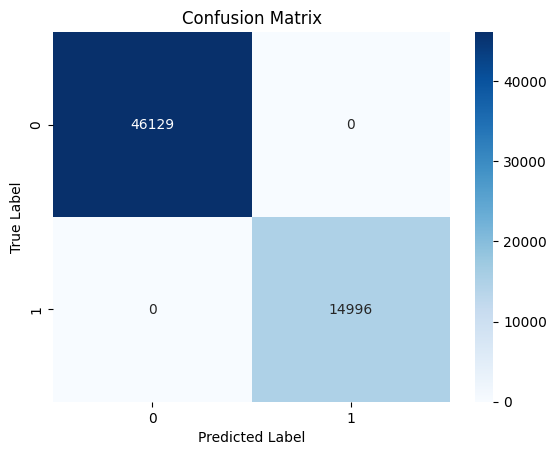

In [17]:
plot_confusion_matrix(y_test, y_pred)


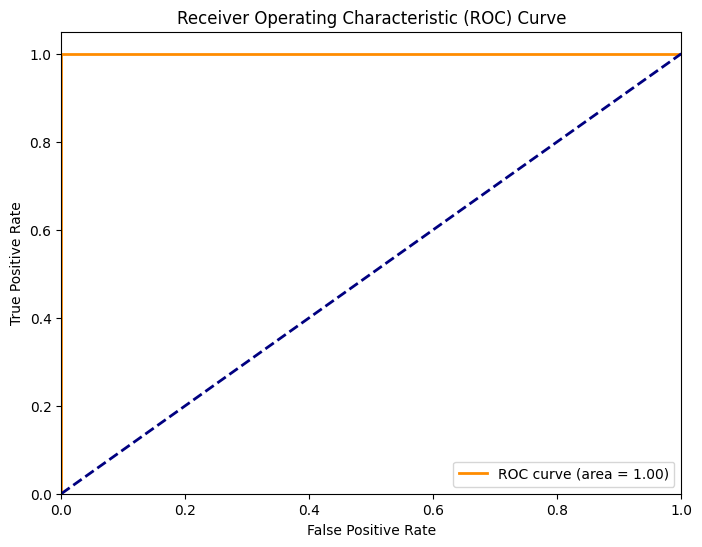

In [18]:
plot_roc_curve(y_test, y_prob)


In [19]:
print_overall_performance(y_test, y_pred)


Overall Accuracy: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     46129
           1       1.00      1.00      1.00     14996

    accuracy                           1.00     61125
   macro avg       1.00      1.00      1.00     61125
weighted avg       1.00      1.00      1.00     61125



## Final step: evaluation of the features

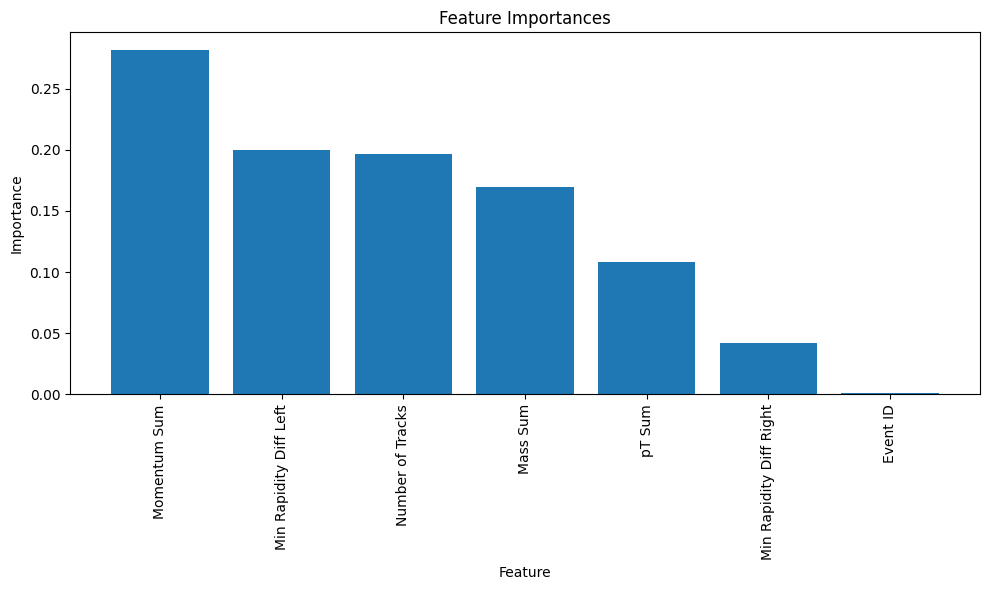

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_feature_importances(model, feature_names):
    """
    Plots the feature importances of a trained model.

    Parameters:
    model: The trained model (e.g., RandomForestClassifier).
    feature_names: A list of feature names corresponding to the model's input features.
    """
    # Get the feature importances from the model
    importances = model.feature_importances_
    
    # Sort the feature importances in descending order
    indices = np.argsort(importances)[::-1]
    
    # Rearrange the feature names so they match the sorted importances
    sorted_feature_names = [feature_names[i] for i in indices]
    
    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances")
    plt.bar(range(len(importances)), importances[indices], align="center")
    plt.xticks(range(len(importances)), sorted_feature_names, rotation=90)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming `model` is your trained RandomForestClassifier and `features_df` contains your features

# Get the feature names
feature_names = features_df.columns

# Plot the feature importances
plot_feature_importances(rf_classifier, feature_names)
